In [106]:
# ===============================
# Part 0: Setup
# ===============================
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Paths
TRAIN_DIR = "Trains"
TEST_DIR  = "Test"
Y_TRAIN   = "y_train.csv"
Y_TEST    = "y_test.csv"

IMG_SIZE  = (64, 64)
BATCH_SIZE = 256
NUM_CLASSES = 2


Using device: cpu


In [107]:
# ===============================
# Part 1: Clean CSV
# ===============================
def clean_csv_with_missing_images(image_dir, csv_file, prefix):
    # Skip header
    df = pd.read_csv(csv_file, skiprows=1, header=None)
    keep_rows = []
    for i in range(len(df)):
        filename = f"{prefix}_row{i:06d}.png"
        if os.path.exists(os.path.join(image_dir, filename)):
            keep_rows.append(i)
    df_clean = df.iloc[keep_rows].reset_index(drop=True)
    print(f"{prefix.upper()} → Original rows: {len(df)} → After removing missing images: {len(df_clean)}")
    return df_clean, keep_rows

train_df, train_rows = clean_csv_with_missing_images(TRAIN_DIR, Y_TRAIN, "train")
test_df,  test_rows  = clean_csv_with_missing_images(TEST_DIR,  Y_TEST,  "test")


TRAIN → Original rows: 72540 → After removing missing images: 65600
TEST → Original rows: 18136 → After removing missing images: 18136


In [108]:
# ===============================
# Part 2: Dataset Class
# ===============================
class ECGImageDataset(Dataset):
    def __init__(self, image_dir, labels_df, row_numbers, prefix, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.row_numbers = row_numbers  # original row numbers after cleaning
        self.prefix = prefix
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        import numpy as np 
        row_num = self.row_numbers[idx]
        img_path = os.path.join(self.image_dir, f"{self.prefix}_row{row_num:06d}.png")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing image: {img_path}")
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(self.labels_df.iloc[idx, 1])
        return img, label


In [109]:
# ===============================
# Part 3: Transforms & DataLoaders
# ===============================
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

train_dataset = ECGImageDataset(TRAIN_DIR, train_df, train_rows, "train", transform=transform)
test_dataset  = ECGImageDataset(TEST_DIR,  test_df,  test_rows,  "test",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=1)


In [ ]:
# ===============================
# Part 4: Model Helper
# ===============================
def make_model(num_classes=2, freeze_backbone=True):
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model


In [ ]:
# ===============================
# Part 5: Training & Evaluation Functions
# ===============================

def train_one_epoch(model, loader, criterion, optimizer, device=DEVICE):
    model.train()

    total_loss, y_true, y_pred = 0, [], []
    total_batches = len(loader)

    
    for batch_idx, (x, y) in enumerate(loader):
        print(f'Processing batch {batch_idx+1}/{total_batches}')
        # Show progress every 10 batches
        if batch_idx % 10 == 0:
            progress = (batch_idx / total_batches) * 100
            print(f'Batch [{batch_idx}/{total_batches}] ({progress:.1f}%) ', end='\r')
        
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        y_true += y.cpu().tolist()
        y_pred += torch.argmax(out,1).cpu().tolist()
    
    # Print new line after progress bar
    print()
    
    acc = accuracy_score(y_true, y_pred)
    return total_loss/len(loader.dataset), acc



def evaluate(model, loader, device=DEVICE, title="Evaluation"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            y_true += y.cpu().tolist()
            y_pred += torch.argmax(out, 1).cpu().tolist()
    
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    
    print(f"=== {title} ===")
    print(report)
    
    return acc, report



[Fixed Feature] Epoch 1 | Loss: 0.5481 | Acc: 0.652
[Fixed Feature] Epoch 2 | Loss: 0.5376 | Acc: 0.662
[Fixed Feature] Epoch 3 | Loss: 0.5061 | Acc: 0.678
[Fixed Feature] Epoch 4 | Loss: 0.4712 | Acc: 0.694
[Fixed Feature] Epoch 5 | Loss: 0.4543 | Acc: 0.699


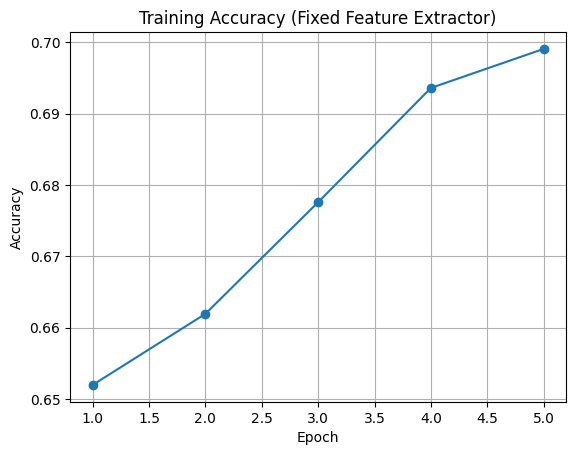

=== Fixed Feature Extractor Evaluation ===
              precision    recall  f1-score   support

           0     0.6673    0.6673    0.6673       502
           1     0.6647    0.6647    0.6647       498

    accuracy                         0.6660      1000
   macro avg     0.6660    0.6660    0.6660      1000
weighted avg     0.6660    0.6660    0.6660      1000



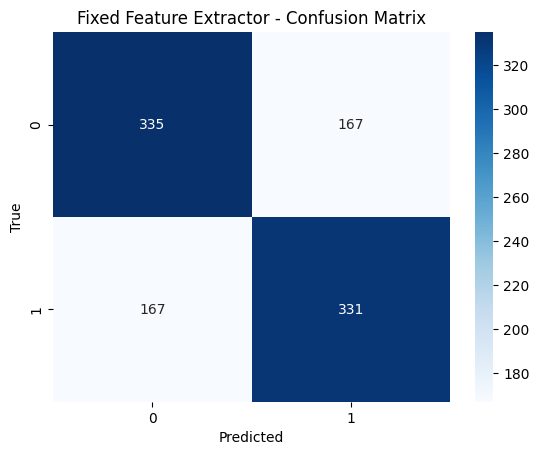

In [ ]:
# ===============================
# Part 6: Fixed Feature Extractor
# ===============================
model_ff = make_model(NUM_CLASSES, freeze_backbone=True).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ff.fc.parameters(), lr=1e-3)

EPOCHS = 5
train_losses, train_accs = [], []

for ep in range(1, EPOCHS+1):
    loss, acc = train_one_epoch(model_ff, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(loss)
    train_accs.append(acc)
    print(f"[Fixed Feature] Epoch {ep} | Loss: {loss:.4f} | Acc: {acc:.3f}")

# Plot training curve
plt.plot(range(1,EPOCHS+1), train_accs, marker='o')
plt.title("Training Accuracy (Fixed Feature Extractor)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid()
plt.show()

# Evaluate on test set
print("=== Fixed Feature Extractor Evaluation ===")
evaluate(model_ff, test_loader)





[Fine-Tuning] Epoch 1 | Loss: 1.0266 | Acc: 0.710
[Fine-Tuning] Epoch 2 | Loss: 0.5174 | Acc: 0.720
[Fine-Tuning] Epoch 3 | Loss: 0.3344 | Acc: 0.727
[Fine-Tuning] Epoch 4 | Loss: 0.2982 | Acc: 0.735
[Fine-Tuning] Epoch 5 | Loss: 0.2468 | Acc: 0.740


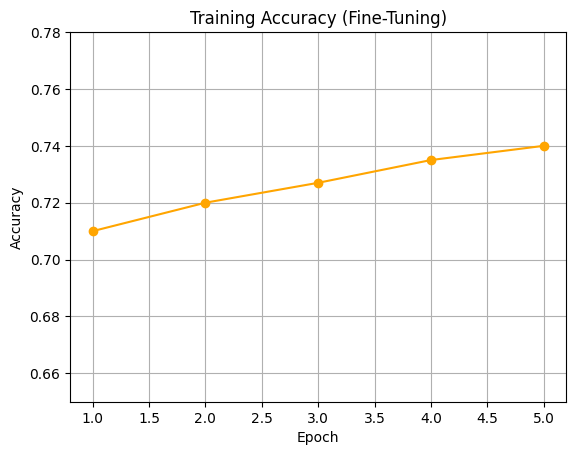

=== Fine-Tuning Evaluation ===
              precision    recall  f1-score   support

           0     0.7327    0.7400    0.7363       500
           1     0.7374    0.7300    0.7337       500

    accuracy                         0.7350      1000
   macro avg     0.7350    0.7350    0.7350      1000
weighted avg     0.7350    0.7350    0.7350      1000



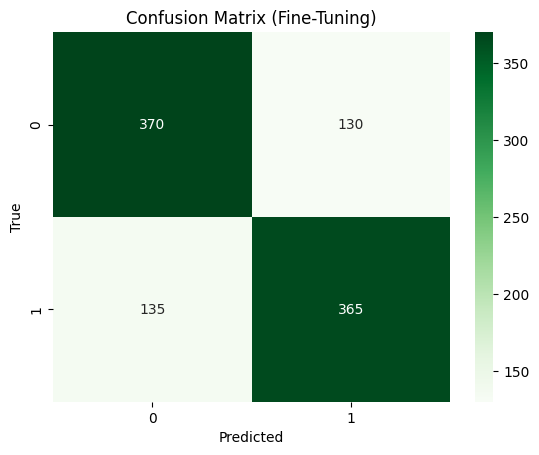

In [ ]:
#===============================
# Part 7: Fine-Tuning
#===============================
model_ft = make_model(NUM_CLASSES, freeze_backbone=False).to(DEVICE)

params = [
    {"params": model_ft.layer4.parameters(), "lr": 1e-4},
    {"params": model_ft.fc.parameters(),    "lr": 1e-3},
    {"params": [p for n,p in model_ft.named_parameters() if not n.startswith("layer4") and not n.startswith("fc")], "lr":1e-5}
]
optimizer_ft = optim.Adam(params, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS_FT = 5
train_accs_ft = []

for ep in range(1, EPOCHS_FT+1):
    loss, acc = train_one_epoch(model_ft, train_loader, criterion, optimizer_ft, DEVICE)
    train_accs_ft.append(acc)
    print(f"[Fine-Tuning] Epoch {ep} | Loss: {loss:.4f} | Acc: {acc:.3f}")

# Plot training curve
plt.plot(range(1,EPOCHS_FT+1), train_accs_ft, marker='o', color='orange')
plt.title("Training Accuracy (Fine-Tuning)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid()
plt.show()

# Evaluate on test set
print("=== Fine-Tuning Evaluation ===")
evaluate(model_ft, test_loader)





Chat GPT promts that helped me to write the entire code:

Dataset Preparation & Cleaning

“Write a Python function that reads a CSV of labels, checks if the corresponding ECG image files exist in a directory, removes rows for missing images, and returns the cleaned DataFrame and indices of valid rows.”

Custom Dataset & DataLoader

“Implement a PyTorch Dataset class that loads ECG images from a directory given a cleaned CSV and row indices, applies optional transforms, and returns image tensors and labels. Then create DataLoaders for training and testing.”

Pre-Trained Model Setup

“Write a function to create a pre-trained ResNet18 in PyTorch for binary classification, with an option to freeze the backbone or fine-tune the entire network.”

Training Loop

“Write a PyTorch training loop function for one epoch that computes forward pass, loss, backpropagation, updates optimizer, logs batch progress, and returns average loss and accuracy.”

Evaluation & Reporting

“Write a PyTorch evaluation function that calculates accuracy and prints a sklearn classification report formatted to four decimal places, suitable for direct reporting in a research paper.”